In [1]:
import collections.abc
import os
import pickle
import pprint

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from openretina.hoefling_2022_configs import model_config, trainer_config
from openretina.hoefling_2022_data_io import natmov_dataloaders_v2
from openretina.hoefling_2022_models import SFB3d_core_SxF3d_readout
from openretina.misc import CustomPrettyPrinter
from openretina.plotting import play_stimulus
from openretina.training import standard_early_stop_trainer as trainer

import wandb

%load_ext autoreload
%autoreload 2

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

pp = CustomPrettyPrinter(indent=4)

In [2]:
# wandb.login()
# run = wandb.init(
#     project="hoefling_2022_reproduction",
#     notes="Testing new dataloading functions.",
#     tags=None,
#     job_type=None,
#     name=None,
# )

# wandb.config.update({**model_config, **trainer_config})

In [3]:
!ls /Data/fd_export

2024-01-11_movies_dict_8c18928.pkl
2024-01-11_movies_dict_c285329.pkl
2024-01-11_neuron_data_stim_8c18928_responses_99c71a0.pkl
2024-01-11_neuron_data_stim_c285329_responses_0698360.pkl
2024-01-11_neuron_data_stim_c285329_responses_483c12d.pkl
dataloaders_stim_8c18928_responses_99c71a0.pkl
dataloaders_stim_c285329_responses_0698360.pkl
dataloaders_stim_c285329_responses_483c12d.pkl
movies_8c18928.pkl
movies_c285329.pkl


In [4]:
base_folder = "/Data/fd_export"
data_path = os.path.join(base_folder, "2024-01-11_neuron_data_stim_8c18928_responses_99c71a0.pkl")
movies_path = os.path.join(base_folder, "2024-01-11_movies_dict_8c18928.pkl")
stim_dataloaders_dict = pickle.load(open(data_path, "rb"))
movies_dict = pickle.load(open(movies_path, "rb"))

In [5]:
model_config["conv_type"] = "time_independent"
dataloaders = natmov_dataloaders_v2(stim_dataloaders_dict, movies_dict, seed=1000)
model = SFB3d_core_SxF3d_readout(**model_config, dataloaders=dataloaders, seed=42)

{'1_ventral1_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 86])}, '2_ventral1_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 65])}, '1_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 90])}, '2_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 95])}, '3_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 115])}, '4_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 77])}, '5_ventral2_20210929': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 83])}, '1_ventral1_20210930': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 69])}, '1_ventral2_20210930': {'inputs': torch.Size([32, 2, 50, 18, 16]), 'targets': torch.Size([32, 50, 103])}, '2_ventral2_20210930': {'inputs': torch.Size([32, 2,

In [7]:
test_score, val_score, output, model_state = trainer(
    model=model,
    dataloaders=dataloaders,
    seed=1000,
    **trainer_config,
    # wandb_logger=run,
)

Random seed 1000 has been set.


Epochs:   0%|          | 0/500 [00:00<?, ?it/s]

In [23]:
print(f"Average test score across sessions: {test_score:.3f}")

Average test score across sessions: 0.298


In [24]:
print(f"Average validation score across sessions: {val_score:.3f}")

Average validation score across sessions: 0.134


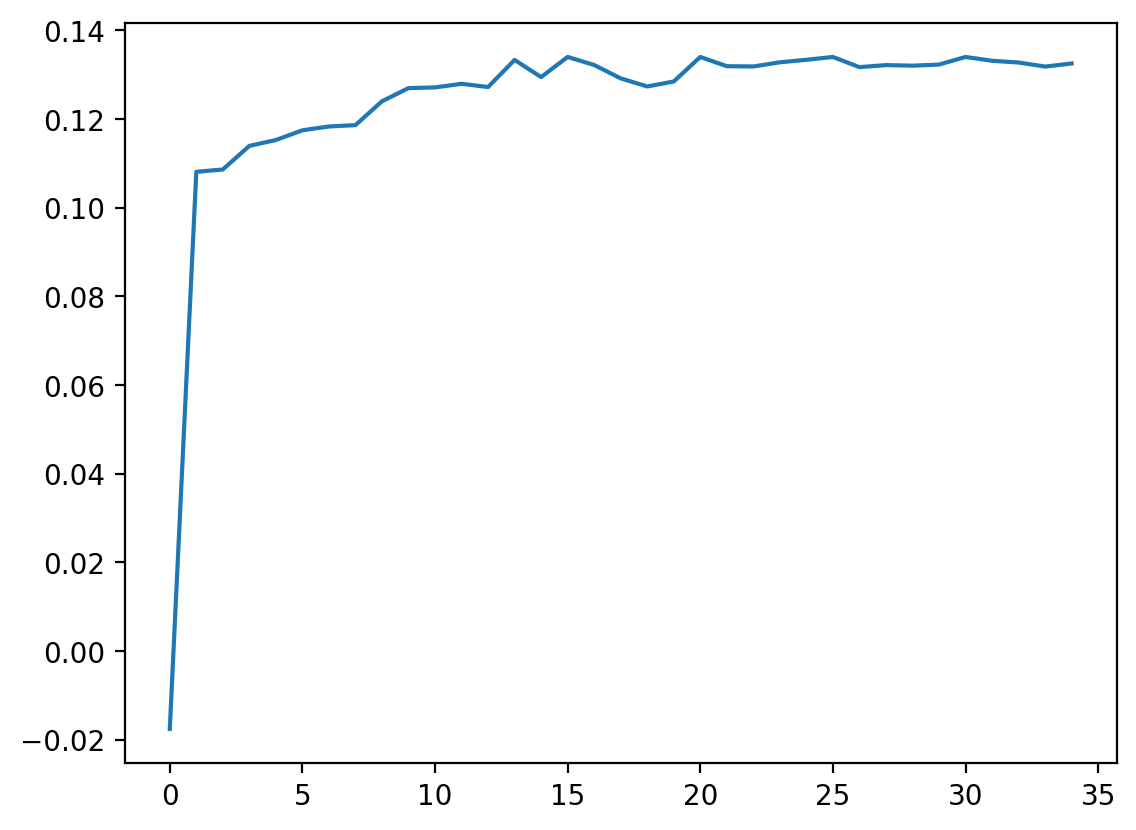

In [10]:
plt.plot(output["val_correlation"])

In [11]:
val_field = "1_ventral1_20210929"
val_sample = next(iter(dataloaders["validation"][val_field]))

In [12]:
input_samples = val_sample.inputs
targets = val_sample.targets

In [13]:
input_samples.shape

torch.Size([15, 2, 150, 18, 16])

In [14]:
with torch.no_grad():
    reconstructions = model(input_samples.to("cuda:0"), val_field)

In [15]:
reconstructions = reconstructions.cpu().numpy().squeeze()
targets = targets.cpu().numpy().squeeze()

In [16]:
targets.shape

(15, 150, 86)

In [17]:
reconstructions.shape

(15, 150, 86)

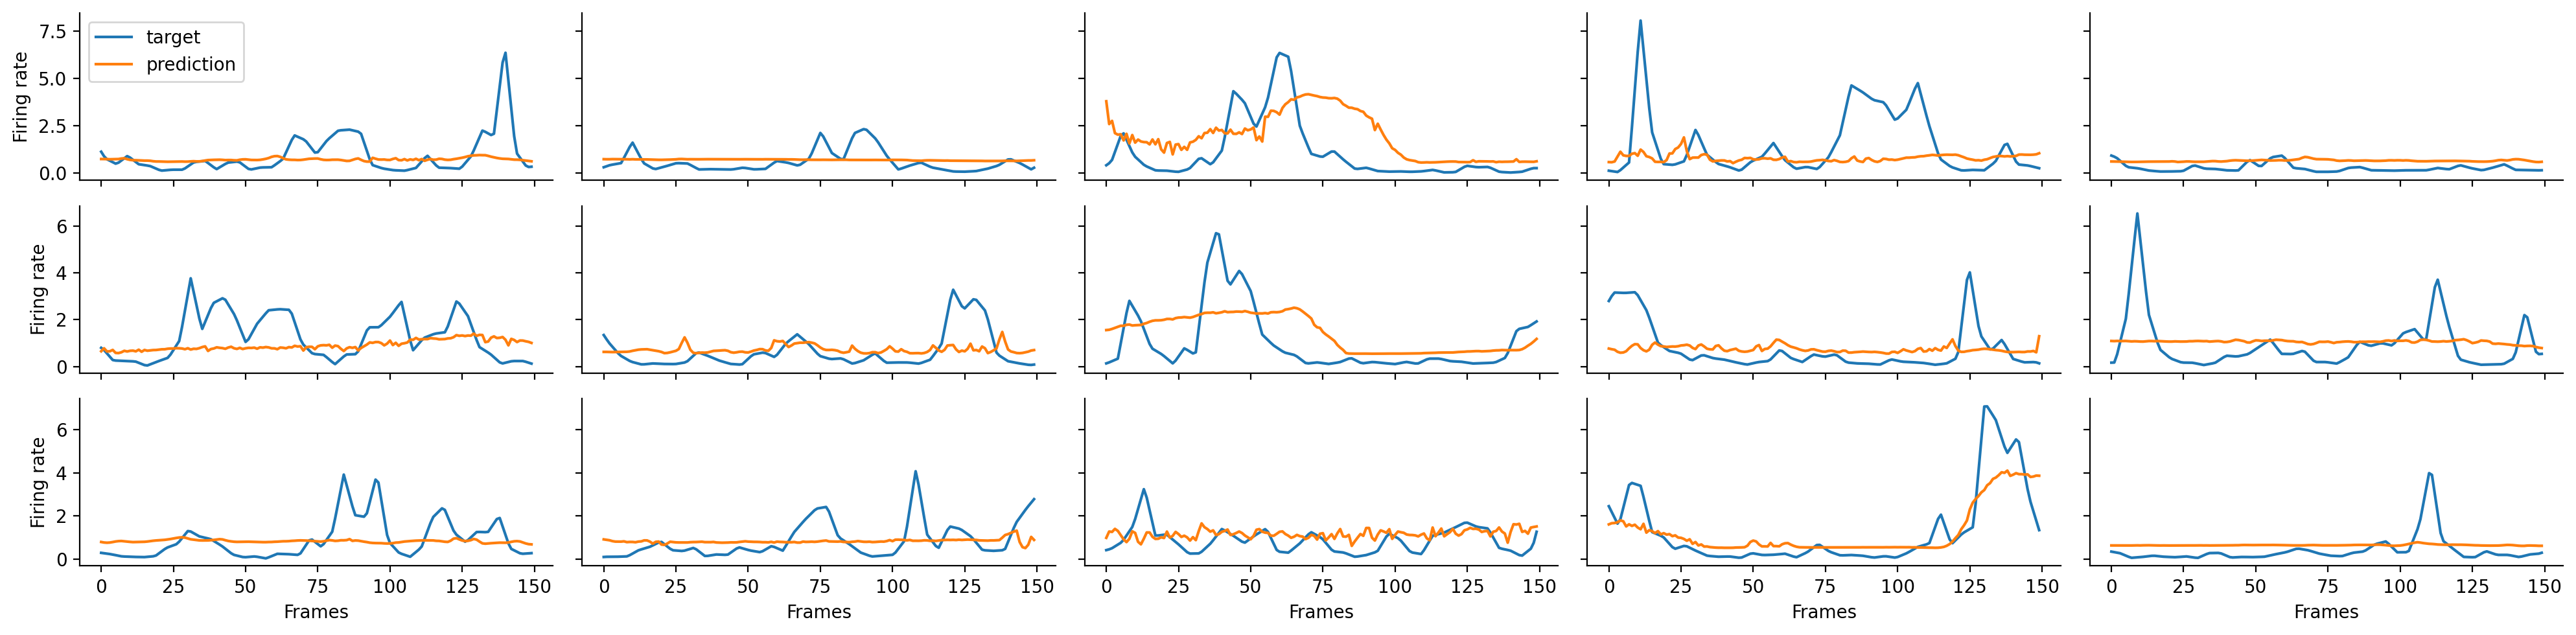

In [20]:
# Your existing code for plotting
neuron = 1
fig, axes = plt.subplots(3, 5, figsize=(20, 5), sharey="row", sharex="col")
for trace_chunk in range(targets.shape[0]):
    ax_idx_1 = trace_chunk // 5
    ax_idx_2 = trace_chunk % 5
    ax = axes[ax_idx_1, ax_idx_2]
    ax.plot(targets[trace_chunk, :, neuron], label="target")
    ax.plot(reconstructions[trace_chunk, :, neuron], label="prediction")

    # Set x and y labels for only outer subplots
    if ax_idx_1 == 2:  # Bottom row
        ax.set_xlabel("Frames")
    if ax_idx_2 == 0:  # Leftmost column
        ax.set_ylabel("Firing rate")

    # # Remove inner labels
    # if ax_idx_1 != 2:
    #     ax.set_xticklabels([])
    # if ax_idx_2 != 0:
    #     ax.set_yticklabels([])
    # Only turn on x-axis labels for the bottom row
    if ax_idx_1 == 2:
        ax.tick_params(labelbottom=True)
    else:
        ax.tick_params(labelbottom=False)

    # Only turn on y-axis labels for the leftmost column
    if ax_idx_2 == 0:
        ax.tick_params(labelleft=True)
    else:
        ax.tick_params(labelleft=False)

# Place the legend outside of the subplots
axes[0, 0].legend()

sns.despine()

# wandb.log({"reconstruction": fig})
plt.tight_layout()

In [19]:
# wandb.finish()

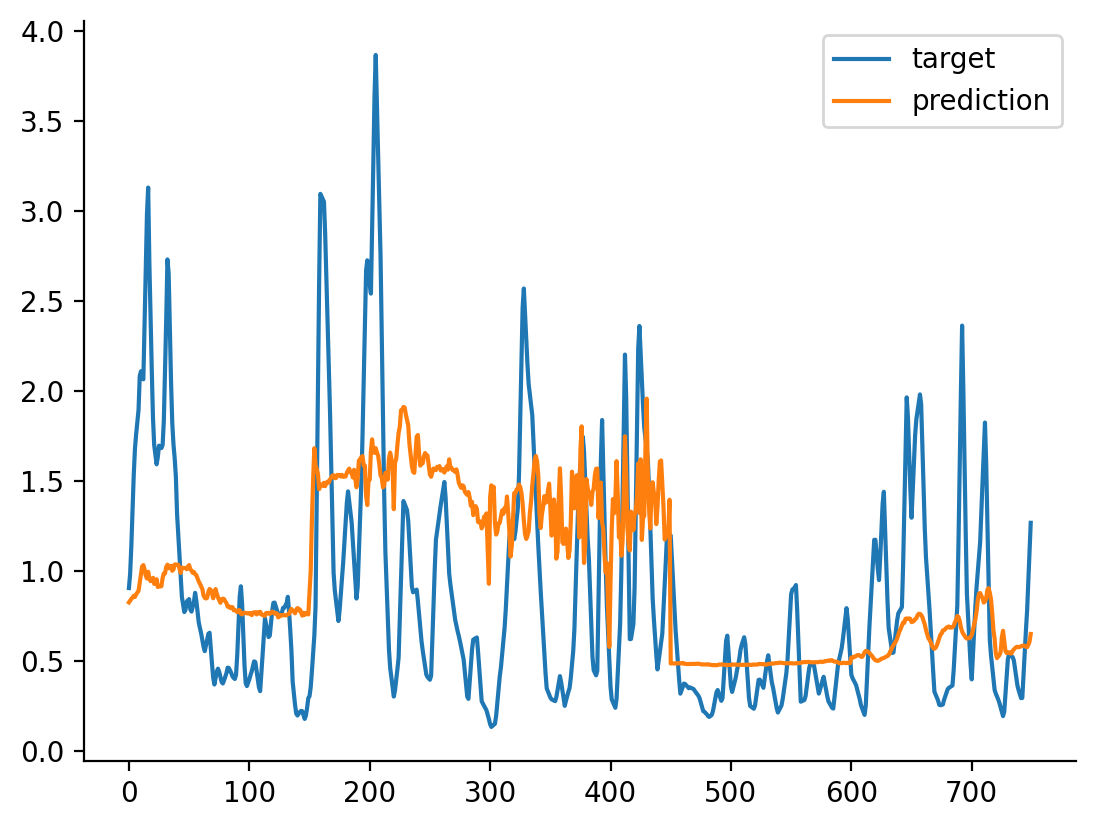

In [22]:
## Plotting an example test field
sample_loader = dataloaders.get("train", dataloaders)
sample_session = list(sample_loader.keys())[0]
test_sample = next(iter(dataloaders["test"][sample_session]))

input_samples = test_sample.inputs
targets = test_sample.targets

model.eval()
model.cpu()

with torch.no_grad():
    reconstructions = model(input_samples.cpu(), sample_session)
reconstructions = reconstructions.cpu().numpy().squeeze()

targets = targets.cpu().numpy().squeeze()
window = 750
neuron = 2
plt.plot(np.arange(0, window), targets[:window, neuron], label="target")
plt.plot(np.arange(0, window), reconstructions[:window, neuron], label="prediction")
plt.legend()
sns.despine()